##### Import and Defining Functions

In [1]:
# Import Required Libraries

import pandas as pd
import math
import numpy as np

import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import iplot

from prophet import Prophet
import holidays
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
import os

from sklearn.preprocessing import MinMaxScaler
import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import shap

C:\Users\Arcega\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    # Return True for Saturday (5) and Sunday (6), False otherwise
    return date.weekday() >= 5

def mean_absolute_scaled_error(y_true, y_pred):
    seasonality = 24

    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the absolute error of the model's predictions
    abs_error = np.mean(np.abs(y_true - y_pred))
    
    # Calculate the naive forecast (seasonal naive) and its errors
    naive_forecast = y_true[:-seasonality]
    naive_errors = np.abs(y_true[seasonality:] - naive_forecast)
    
    # Mean absolute error of the naive forecast
    naive_mae = np.mean(naive_errors)
    
    # MASE calculation
    mase = abs_error / naive_mae
    return mase, naive_forecast

def evaluate_model(test, test_forecast):
    # Evaluate performance
    mse = mean_squared_error(y_true=test['y'],  y_pred=test_forecast['yhat'])
    rmse = np.sqrt(mean_squared_error(y_true=test['y'], y_pred=test_forecast['yhat']))
    mae = mean_absolute_error(y_true=test['y'], y_pred=test_forecast['yhat'])
    r2 = r2_score(y_true=test['y'], y_pred=test_forecast['yhat'])
    return mse, rmse, mae, r2

def df_to_X_y(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size][7]  # 'Entry' is the 8th column (index 7)
        y.append(label)
    return np.array(X), np.array(y)



##### Prophet Model

In [3]:
# Import dataset
df = pd.read_csv('2223TaftProphet.csv', parse_dates=[0])
df

,Datetime,Entry,is_weekend,rain_amount
0,2022-01-01 04:00:00,0,1,0.0
1,2022-01-01 05:00:00,0,1,0.0
2,2022-01-01 06:00:00,525,1,0.0
3,2022-01-01 07:00:00,610,1,0.0
4,2022-01-01 08:00:00,684,1,0.0
...,...,...,...,...
14595,2023-12-31 19:00:00,1681,1,0.0
14596,2023-12-31 20:00:00,297,1,0.0
14597,2023-12-31 21:00:00,0,1,0.0
14598,2023-12-31 22:00:00,0,1,0.0


In [54]:
# Rename header to Prophet's requirements
df.reset_index()
df = df.rename(columns={'Datetime':'ds', 'Entry':'y'})

# Add additional regressors as columns in the dataframe
df['hour'] = pd.to_datetime(df['ds']).dt.hour
df['rush_hour'] = df['ds'].apply(lambda x: 1 if (x.weekday() < 5 and x.hour == 7) else 0)
df['weekend_rush_hour'] = df['ds'].apply(lambda x: 1 if (x.weekday() >= 5 and x.hour == 7) else 0)
df['off_hour'] = df['hour'].apply(lambda x: 1 if (x >= 23) or (x <= 3) else 0)
df['weekday'] = ~df['ds'].apply(is_weekend)
df['weekend'] = df['ds'].apply(is_weekend)

# Extract year, month, day, day of the week, and hour into separate columns
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['day_of_week'] = df['ds'].dt.dayofweek  # Monday=0, Sunday=6
df['hour'] = df['ds'].dt.hour
df

,ds,y,is_weekend,rain_amount,hour,rush_hour,weekend_rush_hour,off_hour,weekday,weekend,year,month,day,day_of_week
0,2022-01-01 04:00:00,0,1,0.0,4,0,0,0,False,True,2022,1,1,5
1,2022-01-01 05:00:00,0,1,0.0,5,0,0,0,False,True,2022,1,1,5
2,2022-01-01 06:00:00,525,1,0.0,6,0,0,0,False,True,2022,1,1,5
3,2022-01-01 07:00:00,610,1,0.0,7,0,1,0,False,True,2022,1,1,5
4,2022-01-01 08:00:00,684,1,0.0,8,0,0,0,False,True,2022,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14595,2023-12-31 19:00:00,1681,1,0.0,19,0,0,0,False,True,2023,12,31,6
14596,2023-12-31 20:00:00,297,1,0.0,20,0,0,0,False,True,2023,12,31,6
14597,2023-12-31 21:00:00,0,1,0.0,21,0,0,0,False,True,2023,12,31,6
14598,2023-12-31 22:00:00,0,1,0.0,22,0,0,0,False,True,2023,12,31,6


In [55]:
# Split the dataset to training and testing sets
train_len = math.floor((df.shape[0]*80)/100)
train = df[:train_len]
test = df[train_len:]

train

,ds,y,is_weekend,rain_amount,hour,rush_hour,weekend_rush_hour,off_hour,weekday,weekend,year,month,day,day_of_week
0,2022-01-01 04:00:00,0,1,0.0,4,0,0,0,False,True,2022,1,1,5
1,2022-01-01 05:00:00,0,1,0.0,5,0,0,0,False,True,2022,1,1,5
2,2022-01-01 06:00:00,525,1,0.0,6,0,0,0,False,True,2022,1,1,5
3,2022-01-01 07:00:00,610,1,0.0,7,0,1,0,False,True,2022,1,1,5
4,2022-01-01 08:00:00,684,1,0.0,8,0,0,0,False,True,2022,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11675,2023-08-07 19:00:00,3812,0,33.0,19,0,0,0,True,False,2023,8,7,0
11676,2023-08-07 20:00:00,2927,0,33.0,20,0,0,0,True,False,2023,8,7,0
11677,2023-08-07 21:00:00,1736,0,33.0,21,0,0,0,True,False,2023,8,7,0
11678,2023-08-07 22:00:00,64,0,33.0,22,0,0,0,True,False,2023,8,7,0


In [56]:
test

,ds,y,is_weekend,rain_amount,hour,rush_hour,weekend_rush_hour,off_hour,weekday,weekend,year,month,day,day_of_week
11680,2023-08-08 04:00:00,0,0,3.5,4,0,0,0,True,False,2023,8,8,1
11681,2023-08-08 05:00:00,2941,0,3.5,5,0,0,0,True,False,2023,8,8,1
11682,2023-08-08 06:00:00,4881,0,3.5,6,0,0,0,True,False,2023,8,8,1
11683,2023-08-08 07:00:00,5821,0,3.5,7,1,0,0,True,False,2023,8,8,1
11684,2023-08-08 08:00:00,4879,0,3.5,8,0,0,0,True,False,2023,8,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14595,2023-12-31 19:00:00,1681,1,0.0,19,0,0,0,False,True,2023,12,31,6
14596,2023-12-31 20:00:00,297,1,0.0,20,0,0,0,False,True,2023,12,31,6
14597,2023-12-31 21:00:00,0,1,0.0,21,0,0,0,False,True,2023,12,31,6
14598,2023-12-31 22:00:00,0,1,0.0,22,0,0,0,False,True,2023,12,31,6


In [57]:
# Visualize the test train split
train_samples = go.Scatter(x = train['ds'],
                  y = train['y'],
                  mode = 'lines',
                  name = 'Train')

test_samples = go.Scatter(x = test['ds'],
                  y = test['y'],
                  mode = 'lines',
                  name = 'Test')

layout = go.Layout(title={'text': 'Train/test split',
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis = dict(title = 'Year'),
                   yaxis = dict(title = 'Entry'),
                   template = 'plotly_dark')

data = [train_samples, test_samples]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [58]:
# Create holidays dataframe
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Philippines(years=[2022, 2023]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

holiday


,ds,holiday
0,2022-01-01,New Year's Day
1,2022-02-01,Chinese New Year
2,2022-02-25,EDSA Revolution Anniversary
3,2022-04-09,Day of Valor
4,2022-04-14,Maundy Thursday
5,2022-04-15,Good Friday
6,2022-04-16,Black Saturday
7,2022-05-01,Labour Day
8,2022-05-02,Eid'l Fitr (estimated)
9,2022-06-12,Independence Day


In [59]:
# Initialize the Prophet model
m = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=True,
    holidays=holiday,
    seasonality_mode='multiplicative'
)

# Add the regressors
m.add_seasonality(name='daily_is_weekend', period=1, fourier_order=4, condition_name='weekend')
m.add_seasonality(name='daily_is_weekday', period=1, fourier_order=4, condition_name='weekday')
m.add_regressor('off_hour')
m.add_regressor('rain_amount')

# Fit the model on the training data
m.fit(train)

23:08:10 - cmdstanpy - INFO - Chain [1] start processing
23:08:30 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
# Make predictions for Test set
test_forecast = m.predict(test)

# Remove negative forecasts
test_forecast['yhat'] = test_forecast['yhat'].apply(lambda x: max(x, 0))
test_forecast['yhat_lower'] = test_forecast['yhat_lower'].apply(lambda x: max(x, 0))
test_forecast['yhat_upper'] = test_forecast['yhat_upper'].apply(lambda x: max(x, 0))

# Round forecast values
test_forecast['yhat'] = test_forecast['yhat'].round()

test_forecast.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Black Saturday,Black Saturday_lower,Black Saturday_upper,Bonifacio Day,Bonifacio Day_lower,Bonifacio Day_upper,Chinese New Year,Chinese New Year_lower,Chinese New Year_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Day of Valor,Day of Valor_lower,Day of Valor_upper,EDSA Revolution Anniversary,EDSA Revolution Anniversary_lower,EDSA Revolution Anniversary_upper,Eid'l Adha (estimated),Eid'l Adha (estimated)_lower,Eid'l Adha (estimated)_upper,Eid'l Fitr (estimated),Eid'l Fitr (estimated)_lower,Eid'l Fitr (estimated)_upper,Good Friday,Good Friday_lower,Good Friday_upper,Immaculate Conception Day,Immaculate Conception Day_lower,Immaculate Conception Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Labour Day,Labour Day_lower,Labour Day_upper,Maundy Thursday,Maundy Thursday_lower,Maundy Thursday_upper,National Heroes Day,National Heroes Day_lower,National Heroes Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Eve,New Year's Eve_lower,New Year's Eve_upper,Ninoy Aquino Day,Ninoy Aquino Day_lower,Ninoy Aquino Day_upper,Rizal Day,Rizal Day_lower,Rizal Day_upper,daily_is_weekday,daily_is_weekday_lower,daily_is_weekday_upper,daily_is_weekend,daily_is_weekend_lower,daily_is_weekend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,off_hour,off_hour_lower,off_hour_upper,rain_amount,rain_amount_lower,rain_amount_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-08-08 04:00:00,1502.743646,0.000000,562.503516,1502.743646,1502.743646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.090264,-1.090264,-1.090264,0.0,0.0,0.0,0.002636,0.002636,0.002636,0.0,0.0,0.0,-1.042875,-1.042875,-1.042875,0.0,0.0,0.0,0.002636,0.002636,0.002636,0.083363,0.083363,0.083363,-0.038610,-0.038610,-0.038610,0.0,0.0,0.0,0.0
1,2023-08-08 05:00:00,1502.802962,2155.904180,3319.649910,1502.802962,1502.802962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.776267,0.776267,0.776267,0.0,0.0,0.0,0.002636,0.002636,0.002636,0.0,0.0,0.0,0.820713,0.820713,0.820713,0.0,0.0,0.0,0.002636,0.002636,0.002636,0.079941,0.079941,0.079941,-0.038131,-0.038131,-0.038131,0.0,0.0,0.0,2736.0
2,2023-08-08 06:00:00,1502.862279,3867.309633,5054.330814,1502.862279,1502.862279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.918330,1.918330,1.918330,0.0,0.0,0.0,0.002636,0.002636,0.002636,0.0,0.0,0.0,1.959646,1.959646,1.959646,0.0,0.0,0.0,0.002636,0.002636,0.002636,0.076329,0.076329,0.076329,-0.037649,-0.037649,-0.037649,0.0,0.0,0.0,4448.0
3,2023-08-08 07:00:00,1502.921595,4265.732514,5421.716542,1502.921595,1502.921595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.168030,2.168030,2.168030,0.0,0.0,0.0,0.002636,0.002636,0.002636,0.0,0.0,0.0,2.206086,2.206086,2.206086,0.0,0.0,0.0,0.002636,0.002636,0.002636,0.072584,0.072584,0.072584,-0.037165,-0.037165,-0.037165,0.0,0.0,0.0,4818.0
4,2023-08-08 08:00:00,1502.980911,3717.335639,4891.559983,1502.98091

In [11]:
# Create a future DataFrame with hourly intervals for the desired forecast period
future = m.make_future_dataframe(periods=150, freq='D')
future['hour'] = pd.to_datetime(future['ds']).dt.hour
future['is_weekend'] = df['is_weekend']
future['weekday'] = future['ds'].apply(is_weekend)
future['weekend'] = ~future['ds'].apply(is_weekend)
future['rain_amount'] = df['rain_amount']
#future['rush_hour'] = future['hour'].apply(lambda x: 1 if (7 == x) else 0)
#future['weekend_rush_hour'] = future['ds'].apply(lambda x: 1 if (x.weekday() >= 5 and x.hour == 7) else 0)
future['off_hour'] = future['hour'].apply(lambda x: 1 if (x >= 23) or (x <= 3) else 0)
future = future[future['ds'].dt.hour < 23]
future = future[future['ds'].dt.hour > 3]

# Make predictions
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01 04:00:00,-172.501401,-824.770699,376.746704
1,2022-01-01 05:00:00,777.059850,210.683671,1395.393425
2,2022-01-01 06:00:00,1356.522595,758.419670,1949.889758
3,2022-01-01 07:00:00,1480.717780,930.907302,2079.086340
4,2022-01-01 08:00:00,1302.629551,742.077921,1881.995843


In [12]:
mse = mean_squared_error(y_true=test['y'],  y_pred=test_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(y_true=test['y'], y_pred=test_forecast['yhat']))
mae = mean_absolute_error(y_true=test['y'], y_pred=test_forecast['yhat'])
r2 = r2_score(y_true=test['y'], y_pred=test_forecast['yhat'])
mase, naive_forecast = mean_absolute_scaled_error(y_true=test['y'],  y_pred=test_forecast['yhat'])

prophet_eval = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R^2 Score', 'MASE', 'Naive Forecast'],
    'Value': [mse, rmse, mae, r2, mase, naive_forecast]
})

prophet_eval

,Metric,Value
0,MSE,390194.771233
1,RMSE,624.655722
2,MAE,424.260274
3,R^2 Score,0.802014
4,MASE,0.243094
5,Naive Forecast,"[0, 2941, 4881, 5821, 4879, 3829, 2955, 2873, ..."


##### LSTM Model

In [13]:
# Load your time series data
df2 = pd.read_csv('2223TaftLSTM.csv')
df2

,Day,Date,Time,Entry,is_weekend,rain_class,rain_amount,rain_desc
0,Saturday,1/1/2022,4:00,0.0,1,0,0.0,No Rain
1,Saturday,1/1/2022,5:00,0.0,1,0,0.0,No Rain
2,Saturday,1/1/2022,6:00,525.0,1,0,0.0,No Rain
3,Saturday,1/1/2022,7:00,610.0,1,0,0.0,No Rain
4,Saturday,1/1/2022,8:00,684.0,1,0,0.0,No Rain
...,...,...,...,...,...,...,...,...
14595,Sunday,12/31/2023,19:00,1681.0,1,0,0.0,No Rain
14596,Sunday,12/31/2023,20:00,297.0,1,0,0.0,No Rain
14597,Sunday,12/31/2023,21:00,0.0,1,0,0.0,No Rain
14598,Sunday,12/31/2023,22:00,0.0,1,0,0.0,No Rain


In [14]:
# Set if holiday
ph_holidays = holidays.PH()
df2['is_holiday'] = df2['Date'].apply(lambda x: 1 if x in ph_holidays else 0)

# Combine 'Date' and 'Time' into a new column 'DateAndTime'
df2['DateAndTime'] = pd.to_datetime(df2['Date'] + ' ' + df2['Time'])

# Drop unneeded columns
df2.drop(['Date', 'Time', 'rain_amount', 'rain_desc'], axis=1, inplace=True)

 # Define additional features
df2['Date Time'] = pd.to_datetime(df2['DateAndTime'], format='%d.%m.%Y %H.%M.%S')
df2['hour'] = df2['Date Time'].dt.hour
df2['day_of_week'] = df2['Date Time'].dt.dayofweek
df2['month'] = df2['Date Time'].dt.month
df2['year'] = df2['Date Time'].dt.year
df2.drop(['DateAndTime', 'Day', 'is_weekend'], axis=1, inplace=True)
df2['is_weekend'] = df2['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
model_features = ['hour', 'day_of_week', 'is_weekend', 'is_holiday', 'month', 'year', 'rain_class', 'Entry']
df_model = df2[model_features]

df_model

,hour,day_of_week,is_weekend,is_holiday,month,year,rain_class,Entry
0,4,5,1,1,1,2022,0,0.0
1,5,5,1,1,1,2022,0,0.0
2,6,5,1,1,1,2022,0,525.0
3,7,5,1,1,1,2022,0,610.0
4,8,5,1,1,1,2022,0,684.0
...,...,...,...,...,...,...,...,...
14595,19,6,1,1,12,2023,0,1681.0
14596,20,6,1,1,12,2023,0,297.0
14597,21,6,1,1,12,2023,0,0.0
14598,22,6,1,1,12,2023,0,0.0


In [21]:
# Normalize all features except 'Entry'
scaler = MinMaxScaler(feature_range=(0, 1))
df_model[df_model.columns[:-1]] = scaler.fit_transform(df_model[df_model.columns[:-1]])

# Save the scaler for the features
joblib.dump(scaler, 'model/scaler_features.pkl')

# Normalize the 'Entry' column separately
scaler_entry = MinMaxScaler(feature_range=(0, 1))
df_model['Entry'] = scaler_entry.fit_transform(df_model[['Entry']])

# Save the scaler for the 'Entry' column
joblib.dump(scaler_entry, 'model/scaler_entry.pkl')

C:\Users\Arcega\AppData\Local\Temp\ipykernel_14752\3301441785.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



FileNotFoundError: [Errno 2] No such file or directory: 'model/scaler_features.pkl'

In [22]:
# Getting X and y values
X, y = df_to_X_y(df_model)

# Determine the split points
train_split_point = int(len(X) * 0.8)
valntest_split_point = int(len(X) * 0.9)

# Split the data
X_train, X_val, X_test = X[:train_split_point], X[train_split_point:valntest_split_point], X[valntest_split_point:]
y_train, y_val, y_test = y[:train_split_point], y[train_split_point:valntest_split_point], y[valntest_split_point:]

In [23]:
# LSTM Model 
model = Sequential()
model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 64)             18688     
                                                                 
 dropout (Dropout)           (None, 6, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 53,825
Trainable params: 53,825
Non-traina

In [51]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the ModelCheckpoint callback with the correct file path
os.makedirs('model', exist_ok=True)
cp1 = ModelCheckpoint(filepath='model/best_lstm.keras', save_best_only=True, monitor='val_loss', mode='min')

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, early_stopping])

Epoch 1/100
365/365 [==============================] - 9s 15ms/step - loss: 0.0235 - val_loss: 0.0103
Epoch 2/100
365/365 [==============================] - 4s 11ms/step - loss: 0.0090 - val_loss: 0.0060
Epoch 3/100
365/365 [==============================] - 4s 11ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 4/100
365/365 [==============================] - 4s 12ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 5/100
365/365 [==============================] - 4s 11ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 6/100
365/365 [==============================] - 4s 11ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 7/100
365/365 [==============================] - 4s 12ms/step - loss: 0.0037 - val_loss: 0.0034

In [53]:
# Assuming df is the original DataFrame with the 'Date Time' column
# Extract the 'Date Time' column for the entire dataset
date_time_test = df2['Date Time']

# Load the scaler for inverse transformation
scaler_entry = joblib.load('model/scaler_entry.pkl')

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
# Create a DataFrame to hold the predictions and actual values
df_pred = pd.DataFrame(y_pred, columns=['Entry'])
df_actual = pd.DataFrame(y_test, columns=['Entry'])

# Inverse transform the 'Entry' column
y_pred_inv = scaler_entry.inverse_transform(df_pred)
y_test_inv = scaler_entry.inverse_transform(df_actual)

# Ensure date_time_test matches the length of y_test_inv and y_pred_inv
date_time_test = date_time_test[-len(y_test_inv):]

# Round the predictions to the nearest whole number and ensure non-negative values
y_pred_inv = np.round(np.maximum(y_pred_inv, 0))
y_test_inv = np.round(np.maximum(y_test_inv, 0))

46/46 [==============================] - 1s 4ms/step


In [54]:
# Calculate evaluation metrics
l_mse = mean_squared_error(y_test_inv, y_pred_inv)
l_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
l_mae = mean_absolute_error(y_test_inv, y_pred_inv)
l_r2 = r2_score(y_test_inv, y_pred_inv)

lstm_eval = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R^2 Score'],
    'Value': [l_mse, l_rmse, l_mae, l_r2]
})

lstm_eval

,Metric,Value
0,MSE,132359.263014
1,RMSE,363.812126
2,MAE,224.117808
3,R^2 Score,0.927905


##### Prophet v LSTM

In [69]:
# Comparing Prophet and LSTM Evaluation
propvlstm = pd.concat([prophet_eval, lstm_eval], axis = 1)
propvlstm

,Metric,Value,Metric,Value
0,MSE,389391.960274,MSE,132359.263014
1,RMSE,624.012789,RMSE,363.812126
2,MAE,424.20274,MAE,224.117808
3,R^2 Score,0.802422,R^2 Score,0.927905
4,MASE,0.243061,NaN,NaN
5,Naive Forecast,"[0, 2941, 4881, 5821, 4879, 3829, 2955, 2873, ...",NaN,NaN


In [16]:
# LSTM Forecast
lstm_forecast = pd.DataFrame(y_pred_inv, columns=['yhat'])
lstm_forecast

NameError: name 'y_pred_inv' is not defined

In [17]:
# Prophet Forecast
test_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Black Saturday,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-08-08 04:00:00,1502.743646,0.000000,522.952693,1502.743646,1502.743646,0.0,0.0,0.0,0.0,...,0.083363,0.083363,0.083363,-0.038610,-0.038610,-0.038610,0.0,0.0,0.0,0.0
1,2023-08-08 05:00:00,1502.802962,2126.411835,3272.328633,1502.802962,1502.802962,0.0,0.0,0.0,0.0,...,0.079941,0.079941,0.079941,-0.038131,-0.038131,-0.038131,0.0,0.0,0.0,2736.0
2,2023-08-08 06:00:00,1502.862279,3885.112693,4987.870124,1502.862279,1502.862279,0.0,0.0,0.0,0.0,...,0.076329,0.076329,0.076329,-0.037649,-0.037649,-0.037649,0.0,0.0,0.0,4448.0
3,2023-08-08 07:00:00,1502.921595,4233.948706,5379.233860,1502.921595,1502.921595,0.0,0.0,0.0,0.0,...,0.072584,0.072584,0.072584,-0.037165,-0.037165,-0.037165,0.0,0.0,0.0,4818.0
4,2023-08-08 08:00:00,1502.980911,3739.287819,4876.376142,1502.980911,1502.980911,0.0,0.0,0.0,0.0,...,0.068760,0.068760,0.068760,-0.036677,-0.036677,-0.036677,0.0,0.0,0.0,4298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2023-12-31 19:00:00,1710.054302,0.000000,5418.175158,-755.902703,3901.066970,0.0,0.0,0.0,0.0,...,-0.080293,-0.080293,-0.080293,-0.010234,-0.010234,-0.010234,0.0,0.0,0.0,2322.0
2916,2023-12-31 20:00:00,1710.113618,0.000000,4185.774780,-757.008619,3901.872411,0.0,0.0,0.0,0.0,...,-0.071339,-0.071339,-0.071339,-0.009755,-0.009755,-0.009755,0.0,0.0,0.0,1778.0
2917,2023-12-31 21:00:00,1710.172935,0.000000,1796.685258,-758.045740,3902.677851,0.0,0.0,0.0,0.0,...,-0.061977,-0.061977,-0.061977,-0.009277,-0.009277,-0.009277,0.0,0.0,0.0,688.0
2918,2023-12-31 22:00:00,1710.232251,0.000000,540.522993,-759.082860,3903.483292,0.0,0.0,0.0,0.0,...,-0.052290,-0.052290,-0.052290,-0.008801,-0.008801,-0.008801,0.0,0.0,0.0,0.0


In [18]:
# Get the number of rows
num_rows = len(test_forecast)

# Calculate the midpoint
midpoint = num_rows // 2

# Take the latter half
prophet_forecast = test_forecast[midpoint:]
test_one = test[:midpoint]
hybrid_actual = test[midpoint:]

# Reset the index of the DataFrame and drop the old index
prophet_forecast.reset_index(drop=True, inplace=True)
hybrid_actual.reset_index(drop=True, inplace=True)

prophet_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Black Saturday,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-10-20 04:00:00,1606.665897,0.000000,294.451823,750.476774,2379.048867,0.0,0.0,0.0,0.0,...,-0.026443,-0.026443,-0.026443,-0.064640,-0.064640,-0.064640,0.0,0.0,0.0,0.0
1,2023-10-20 05:00:00,1606.725214,1124.964300,4035.635268,749.651304,2380.231372,0.0,0.0,0.0,0.0,...,-0.021457,-0.021457,-0.021457,-0.065450,-0.065450,-0.065450,0.0,0.0,0.0,2664.0
2,2023-10-20 06:00:00,1606.784530,1921.929532,6684.411859,748.825834,2381.413878,0.0,0.0,0.0,0.0,...,-0.016175,-0.016175,-0.016175,-0.066255,-0.066255,-0.066255,0.0,0.0,0.0,4507.0
3,2023-10-20 07:00:00,1606.843846,2182.034365,7276.114476,748.000364,2382.596383,0.0,0.0,0.0,0.0,...,-0.010652,-0.010652,-0.010652,-0.067057,-0.067057,-0.067057,0.0,0.0,0.0,4916.0
4,2023-10-20 08:00:00,1606.903163,1872.119485,6627.966636,747.174893,2383.778889,0.0,0.0,0.0,0.0,...,-0.004951,-0.004951,-0.004951,-0.067854,-0.067854,-0.067854,0.0,0.0,0.0,4372.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2023-12-31 19:00:00,1710.054302,0.000000,5418.175158,-755.902703,3901.066970,0.0,0.0,0.0,0.0,...,-0.080293,-0.080293,-0.080293,-0.010234,-0.010234,-0.010234,0.0,0.0,0.0,2322.0
1456,2023-12-31 20:00:00,1710.113618,0.000000,4185.774780,-757.008619,3901.872411,0.0,0.0,0.0,0.0,...,-0.071339,-0.071339,-0.071339,-0.009755,-0.009755,-0.009755,0.0,0.0,0.0,1778.0
1457,2023-12-31 21:00:00,1710.172935,0.000000,1796.685258,-758.045740,3902.677851,0.0,0.0,0.0,0.0,...,-0.061977,-0.061977,-0.061977,-0.009277,-0.009277,-0.009277,0.0,0.0,0.0,688.0
1458,2023-12-31 22:00:00,1710.232251,0.000000,540.522993,-759.082860,3903.483292,0.0,0.0,0.0,0.0,...,-0.052290,-0.052290,-0.052290,-0.008801,-0.008801,-0.008801,0.0,0.0,0.0,0.0


In [19]:
hybrid_forecast = prophet_forecast[['ds', 'yhat']].rename(columns={'yhat': 'prophet'})
hybrid_forecast['lstm'] = lstm_forecast['yhat']
hybrid_forecast['y'] = hybrid_actual['y']
print(hybrid_forecast)

NameError: name 'lstm_forecast' is not defined

In [20]:
# Evaluate Prophet Forecast
mse, rmse, mae, r2, mase, naive_forecast = evaluate_model(hybrid_forecast,prophet_forecast)

prop_for_eval = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R^2 Score', 'MASE', 'Naive Forecast'],
    'Value': [mse, rmse, mae, r2, mase, naive_forecast]
})

prop_for_eval

KeyError: 'y'

In [77]:
# Evaluate LSTM Forecast
mse, rmse, mae, r2, mase, naive_forecast = evaluate_model(hybrid_forecast,lstm_forecast)

lstm_for_eval = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R^2 Score', 'MASE'],
    'Value': [mse, rmse, mae, r2, mase]
})

lstm_for_eval

,Metric,Value
0,MSE,132359.263014
1,RMSE,363.812126
2,MAE,224.117808
3,R^2 Score,0.927905
4,MASE,0.137010


In [78]:
# Comparing Prophet and LSTM Evaluation
fore_propvlstm = pd.concat([prop_for_eval, lstm_for_eval], axis = 1)
fore_propvlstm

,Metric,Value,Metric,Value
0,MSE,439492.005479,MSE,132359.263014
1,RMSE,662.941932,RMSE,363.812126
2,MAE,460.835616,MAE,224.117808
3,R^2 Score,0.760611,R^2 Score,0.927905
4,MASE,0.281723,MASE,0.137010
5,Naive Forecast,"[0, 2894, 4339, 5548, 4502, 3705, 2972, 2880, ...",NaN,NaN


##### Hybrid Model (Weighted Average)

In [79]:
# Define weights
weight_prophet =0.1
weight_lstm = 0.9

In [80]:
# Calculate the hybrid forecast
hybrid_forecast['yhat'] = (
    weight_prophet * hybrid_forecast['prophet'] + 
    weight_lstm * hybrid_forecast['lstm']
)

In [81]:
actual = hybrid_forecast['y']
actual

0          0
1       2894
2       4339
3       5548
4       4502
        ... 
1455    1681
1456     297
1457       0
1458       0
1459       0
Name: y, Length: 1460, dtype: int64

In [82]:
forecast = hybrid_forecast['yhat']
forecast

0         59.399998
1       2631.000049
2       4730.200000
3       5645.699805
4       4547.399805
           ...     
1455    1672.899951
1456    1193.000000
1457     110.499997
1458      28.799999
1459       0.000000
Name: yhat, Length: 1460, dtype: float64

In [84]:
#Evaluate hybrid forecast
mse, rmse, mae, r2, mase = evaluate_model(hybrid_forecast, hybrid_forecast)

hybrid_eval = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R^2 Score', 'MASE'],
    'Value': [mse, rmse, mae, r2, mase]
})

hybrid_eval

ValueError: too many values to unpack (expected 5)

##### SHAP Implementation

###### LSTM w/ SHAP

In [24]:
# Create a background dataset for SHAP using a larger sample from the training set
background = X_train[np.random.choice(X_train.shape[0], min(1000, X_train.shape[0]), replace=False)]

# Initialize SHAP GradientExplainer
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for the entire test dataset
shap_values = explainer.shap_values(X_test)

# Check the shape of shap_values
print("Original SHAP values shape:", shap_values.shape)

# Reshape the SHAP values to (n_samples, n_timesteps, n_features)
shap_values_flat = shap_values.reshape(X_test.shape[0], 19, -1)
print("Reshaped SHAP values shape:", shap_values_flat.shape)

# Average across the time steps
shap_values_avg = np.mean(shap_values_flat, axis=1)  # Now the shape will be (n_samples, n_features)
print("Averaged SHAP values shape:", shap_values_avg.shape)

# Prepare X_test for plotting (only keep the features excluding 'Entry')
X_test_flat = X_test[:, -1, :-1]  # Take the last time step and exclude 'Entry'
print("X_test_flat shape:", X_test_flat.shape)

# Ensure the number of features matches (we will take only the first 7 features for SHAP)
shap_values_avg = shap_values_avg[:, :-1]  # Exclude the last feature to match

# Now the shapes should match
assert shap_values_avg.shape[1] == X_test_flat.shape[1], \
    f"SHAP values shape: {shap_values_avg.shape[1]}, X_test_flat shape: {X_test_flat.shape[1]}"

# Define feature names according to your dataset (excluding 'Entry')
feature_names = ['Hour', 'Day of Week', 'Is Weekend', 'Is Holiday', 'Month', 'Year', 'Rain Class']

# Plot the SHAP summary with feature names
shap.summary_plot(shap_values_avg, X_test_flat, feature_names=feature_names)


C:\Users\Arcega\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py:451: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



KeyboardInterrupt: 

###### Prophet w/ SHAP


100%|██████████| 100/100 [12:03<00:00,  7.23s/it]


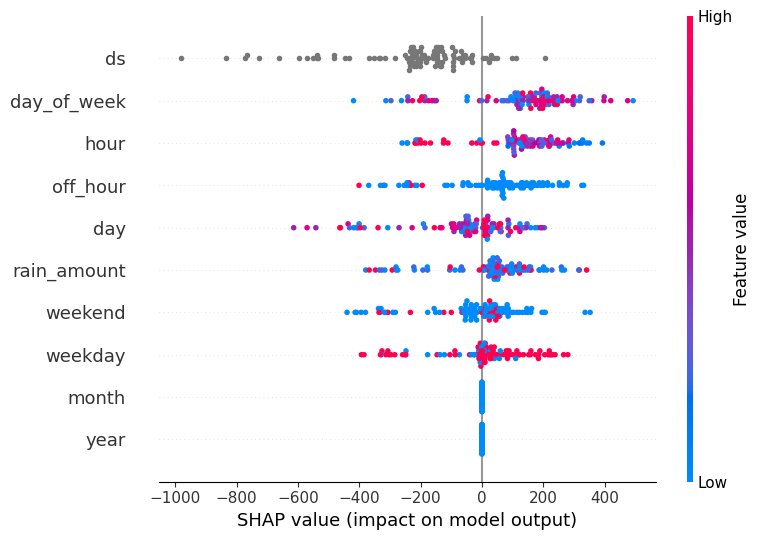

In [62]:
# Prepare the data for SHAP
# Use the same features that were used in the Prophet model
shap_features = ['ds', 'year','month', 'day', 'day_of_week', 'hour','off_hour', 'rain_amount', 'weekday', 'weekend']

# Extract the feature values from the test set
shap_values_df = test[shap_features]
shap_values_df = shap_values_df[:100]

def prophet_predict(data):
    future = pd.DataFrame(data, columns=['ds', 'year','month', 'day', 'day_of_week', 'hour','off_hour', 'rain_amount', 'weekday', 'weekend'])
    forecast = m.predict(future)
    return forecast['yhat'].values

# Initialize SHAP KernelExplainer with the Prophet model
explainer = shap.KernelExplainer(prophet_predict, shap_values_df)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(shap_values_df)

# Plot the SHAP summary
shap.summary_plot(shap_values, shap_values_df, feature_names=shap_features)

In [48]:
test_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Black Saturday,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-08-08 04:00:00,1502.743646,0.000000,522.952693,1502.743646,1502.743646,0.0,0.0,0.0,0.0,...,0.083363,0.083363,0.083363,-0.038610,-0.038610,-0.038610,0.0,0.0,0.0,0.0
1,2023-08-08 05:00:00,1502.802962,2126.411835,3272.328633,1502.802962,1502.802962,0.0,0.0,0.0,0.0,...,0.079941,0.079941,0.079941,-0.038131,-0.038131,-0.038131,0.0,0.0,0.0,2736.0
2,2023-08-08 06:00:00,1502.862279,3885.112693,4987.870124,1502.862279,1502.862279,0.0,0.0,0.0,0.0,...,0.076329,0.076329,0.076329,-0.037649,-0.037649,-0.037649,0.0,0.0,0.0,4448.0
3,2023-08-08 07:00:00,1502.921595,4233.948706,5379.233860,1502.921595,1502.921595,0.0,0.0,0.0,0.0,...,0.072584,0.072584,0.072584,-0.037165,-0.037165,-0.037165,0.0,0.0,0.0,4818.0
4,2023-08-08 08:00:00,1502.980911,3739.287819,4876.376142,1502.980911,1502.980911,0.0,0.0,0.0,0.0,...,0.068760,0.068760,0.068760,-0.036677,-0.036677,-0.036677,0.0,0.0,0.0,4298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2023-12-31 19:00:00,1710.054302,0.000000,5418.175158,-755.902703,3901.066970,0.0,0.0,0.0,0.0,...,-0.080293,-0.080293,-0.080293,-0.010234,-0.010234,-0.010234,0.0,0.0,0.0,2322.0
2916,2023-12-31 20:00:00,1710.113618,0.000000,4185.774780,-757.008619,3901.872411,0.0,0.0,0.0,0.0,...,-0.071339,-0.071339,-0.071339,-0.009755,-0.009755,-0.009755,0.0,0.0,0.0,1778.0
2917,2023-12-31 21:00:00,1710.172935,0.000000,1796.685258,-758.045740,3902.677851,0.0,0.0,0.0,0.0,...,-0.061977,-0.061977,-0.061977,-0.009277,-0.009277,-0.009277,0.0,0.0,0.0,688.0
2918,2023-12-31 22:00:00,1710.232251,0.000000,540.522993,-759.082860,3903.483292,0.0,0.0,0.0,0.0,...,-0.052290,-0.052290,-0.052290,-0.008801,-0.008801,-0.008801,0.0,0.0,0.0,0.0


In [51]:
# To display all columns in the DataFrame
pd.set_option('display.max_columns', None)

# Now, when you print the DataFrame, it will show all the columns
test_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Black Saturday,Black Saturday_lower,Black Saturday_upper,Bonifacio Day,Bonifacio Day_lower,Bonifacio Day_upper,Chinese New Year,Chinese New Year_lower,Chinese New Year_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Day of Valor,Day of Valor_lower,Day of Valor_upper,EDSA Revolution Anniversary,EDSA Revolution Anniversary_lower,EDSA Revolution Anniversary_upper,Eid'l Adha (estimated),Eid'l Adha (estimated)_lower,Eid'l Adha (estimated)_upper,Eid'l Fitr (estimated),Eid'l Fitr (estimated)_lower,Eid'l Fitr (estimated)_upper,Good Friday,Good Friday_lower,Good Friday_upper,Immaculate Conception Day,Immaculate Conception Day_lower,Immaculate Conception Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Labour Day,Labour Day_lower,Labour Day_upper,Maundy Thursday,Maundy Thursday_lower,Maundy Thursday_upper,National Heroes Day,National Heroes Day_lower,National Heroes Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,New Year's Eve,New Year's Eve_lower,New Year's Eve_upper,Ninoy Aquino Day,Ninoy Aquino Day_lower,Ninoy Aquino Day_upper,Rizal Day,Rizal Day_lower,Rizal Day_upper,daily_is_weekday,daily_is_weekday_lower,daily_is_weekday_upper,daily_is_weekend,daily_is_weekend_lower,daily_is_weekend_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,off_hour,off_hour_lower,off_hour_upper,rain_amount,rain_amount_lower,rain_amount_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2023-08-08 04:00:00,1502.743646,0.000000,522.952693,1502.743646,1502.743646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.090264,-1.090264,-1.090264,0.000000,0.000000,0.000000,0.002636,0.002636,0.002636,0.000000,0.000000,0.000000,-1.042875,-1.042875,-1.042875,0.00000,0.00000,0.00000,0.002636,0.002636,0.002636,0.083363,0.083363,0.083363,-0.038610,-0.038610,-0.038610,0.0,0.0,0.0,0.0
1,2023-08-08 05:00:00,1502.802962,2126.411835,3272.328633,1502.802962,1502.802962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.776267,0.776267,0.776267,0.000000,0.000000,0.000000,0.002636,0.002636,0.002636,0.000000,0.000000,0.000000,0.820713,0.820713,0.820713,0.00000,0.00000,0.00000,0.002636,0.002636,0.002636,0.079941,0.079941,0.079941,-0.038131,-0.038131,-0.038131,0.0,0.0,0.0,2736.0
2,2023-08-08 06:00:00,1502.862279,3885.112693,4987.870124,1502.862279,1502.862279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.918330,1.918330,1.918330,0.000000,0.000000,0.000000,0.002636,0.002636,0.002636,0.000000,0.000000,0.000000,1.959646,1.959646,1.959646,0.00000,0.00000,0.00000,0.002636,0.002636,0.002636,0.076329,0.076329,0.076329,-0.037649,-0.037649,-0.037649,0.0,0.0,0.0,4448.0
3,2023-08-08 07:00:00,1502.921595,4233.948706,5379.233860,1502.921595,1502.921595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.168030,2.168030,2.168030,0.000000,0.000000,0.000000,0.002636,0.002636,0.002636,0.000000,0.000000,0.0